# Geometric Multi-Resolution Analysis (GMRA)

GMRA approximates point clouds in high-dimensional datasets. It involves two components:

1. A partitioning function which partitions a high-dimensional space into local cells based on a dataset
$$\mathbb{R}^D\supset \{x_i\}_{i=1}^N\longrightarrow \{Q_j\}_{j=1}^k$$
2. A local modeling function which takes data from local cells and provides local encoder/decoders for representation/reconstruction of new datapoints
$$\{x_i\}_{i=1}^N \cup Q_j \longrightarrow (\mathcal{E}_j,\:\mathcal{D}_j)$$

GMRA may be thought of as an extension of dimension reduction techniques. Just as Principal Component Analysis (PCA) is used to reduce dimension to make classification and regression practical, GMRA provides a low-complexity representation that can be exploited improve computational and statistical efficiency. 

Our visualization use Mathbox2. We begin with code developed by znah@github to place python arrays into jupyter's javascript global scope.

In [1]:
import json
import numpy as np
import numpy.random as rd
from IPython.display import HTML, Javascript, display

def json_numpy_serializer(o):
    if isinstance(o, np.ndarray):
        return o.tolist()
    raise TypeError("{} of type {} is not JSON serializable".format(repr(o), type(o)))

def jsglobal(**params):
    code = [];
    for name, value in params.items():
        jsdata = json.dumps(value, default=json_numpy_serializer)
        code.append("window.{}={};".format(name, jsdata))
    display(Javascript("\n".join(code)))

## GMRA experiments

For each experiment, we draw $10^4$ points from the unit sphere and construct a GMRA at a particular scale. We consider three succesively finer scales to depict the approximation errors. 

Our partitioning function is based on the cover tree algorithm, and our local models are PCA approximations.

For each experiment, we compose the encode and decode functions of the GMRA to each data apoint to determine the GMRA approximation to the sphere at each scale. These point clouds are then passed to the javascript global scope for visualization.

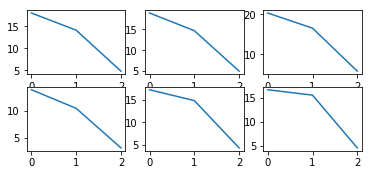

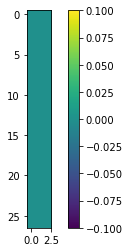

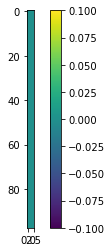

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
from partition import uniform_covertree_partition
from local import pca_coder
from local_info import local_pca_info
from gmra import GMRA

def gmra_sphere_experiment(num_pts, scale):
    data = np.reshape(rd.randn(3*num_pts), (num_pts, 3))
    data = np.apply_along_axis(lambda v: v / np.sqrt(np.sum(v**2)), 1, data)
    
    sphere_gmra = GMRA(data, lambda d, m: uniform_covertree_partition(d, m, scale=scale), pca_coder, info_fcn=local_pca_info) 
    sphere_gmra.info()

    x = []
    y = []
    z = []

    for i in range(num_pts):
        idx, code = sphere_gmra.encode(data[i,:])
        v = sphere_gmra.decode(idx, code)
        x.append(v[0])
        y.append(v[1])
        z.append(v[2])

    pos = np.vstack([x, y, z]).T
    return pos
    
pos0 = gmra_sphere_experiment(10000, 0)
pos1 = gmra_sphere_experiment(10000, -1)
pos2 = gmra_sphere_experiment(10000, -2)
        
jsglobal(POS0=pos0)
jsglobal(POS1=pos1)
jsglobal(POS2=pos2)

## Visualizations

We now call Mathbox2 for each GMRA approximation point cloud to visualize our results.

In [3]:
%%javascript

// window.location.reload(true)

// Loading the compiled MathBox bundle.
require.config({
    paths: {
        mathBox: '//cdn.rawgit.com/unconed/mathbox/eaeb8e15/build/mathbox-bundle'
    }
});

// Helper function that setups WebGL context and initializes MathBox.
window.with_mathbox = function(element, func) {
    require(['mathBox'], function(){
        var mathbox = mathBox({
          plugins: ['core', 'controls', 'cursor', 'mathbox'],
          controls: { klass: THREE.OrbitControls },
          mathbox: {inspect: false},
          element: element[0],
          loop: {start: false},
            
        });
        var three = mathbox.three;
        three.renderer.setClearColor(new THREE.Color(0xFFFFFF), 1.0);
        three.camera.position.set(-1, 1, 2);
        three.controls.noKeys = true;
        
        three.element.style.height = "400px";
        three.element.style.width = "100%";
        
        function isInViewport(element) {
          var rect = element.getBoundingClientRect();
          var html = document.documentElement;
          var w = window.innerWidth || html.clientWidth;
          var h = window.innerHeight || html.clientHeight;
          return rect.top < h && rect.left < w && rect.bottom > 0 && rect.right > 0;
        }
        
        // Running update/render loop only for visible plots.
        var intervalId = setInterval(function(){
            if (three.element.offsetParent === null) {
                clearInterval(intervalId);
                three.destroy();
                return;
            }
            var visible = isInViewport(three.canvas);
            if (three.Loop.running != visible) {
                visible? three.Loop.start() : three.Loop.stop();
            }
        }, 100);

        func(mathbox);
        
        window.dispatchEvent(new Event('resize'));
    })
}

<IPython.core.display.Javascript object>

In [4]:
%%javascript
with_mathbox(element, function(mathbox) {
    
    var view = mathbox.cartesian({},{rotation:(t)=>[0, t*0.02, 0]})
      .grid({axes: [1, 3]})
    
    view.array({
        width: POS0.length,
      expr: function (emit, i, time) {
            emit(POS0[i][0], POS0[i][1], POS0[i][2]);
      },
      channels: 3
    });
        
    // Now we can see the data on JS side!
    view.point({color:"#55a", size: 4});
    
})

<IPython.core.display.Javascript object>

In [5]:
%%javascript
with_mathbox(element, function(mathbox) {
    
    var view = mathbox.cartesian({},{rotation:(t)=>[0, t*0.02, 0]})
      .grid({axes: [1, 3]})
    
    view.array({
        width: POS1.length,
      expr: function (emit, i, time) {
            emit(POS1[i][0], POS1[i][1], POS1[i][2]);
      },
      channels: 3
    });
        
    // Now we can see the data on JS side!
    view.point({color:"#55a", size: 4});
    
})

<IPython.core.display.Javascript object>

In [6]:
%%javascript
with_mathbox(element, function(mathbox) {
    
    var view = mathbox.cartesian({},{rotation:(t)=>[0, t*0.02, 0]})
      .grid({axes: [1, 3]})
    
    view.array({
        width: POS2.length,
      expr: function (emit, i, time) {
            emit(POS2[i][0], POS2[i][1], POS2[i][2]);
      },
      channels: 3
    });
        
    // Now we can see the data on JS side!
    view.point({color:"#55a", size: 4});
    
})

<IPython.core.display.Javascript object>